# Unit 3

Unit 3 covers the basics of Stable Diffusion. So far what we have been learning is Diffusion model. This notebook covers:
- Generating images from text using StableDiffusionPipeline and experimenting with the available arguments.
- Seeing some of the key pipeline components in action
    - The VAE that makes this a 'latent diffusion model'
    - The tokenizer and text encoder that process the text prompt
    - The UNet model
    - The scheduler, and exploring different schedulers
- Replicating the sampling loop with the pipeline components
- Editing existing images with the Img2Img pipeline
- Using inpainting and Depth2Img pipelines

# Packages

In [1]:
# Pytorch to use and train models
import torch
# requests package is used to access a website url
import requests
# Image is for accessing and customizing the images
from PIL import Image
# BytesIO is used to manupulate the byte data
from io import BytesIO
# pyplot can be used for generating graphs
from matplotlib import pyplot as plt

# The pipelines which we are going to explore
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline,
    StableDiffusionDepth2ImgPipeline
)

device = ("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
# We will use couple of demo images later in notebook
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

# Download images for inpainting example
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

## Generating Images from Text

In [3]:
# loading the pipeling
model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

safety_checker\model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/35 [00:00<?, ?it/s]

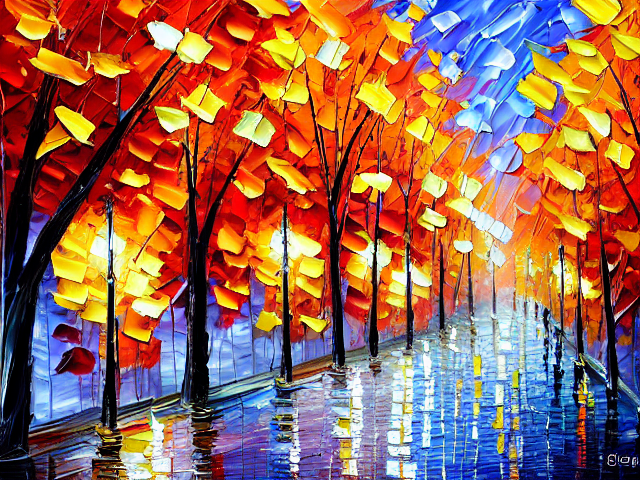

In [4]:
# Setting up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

# Running the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape", # What to generate
    negative_prompt="Oversaturated, blurry, low quality", # What NOT to generate
    height=480, width=640,     # Specify the image size
    guidance_scale=8,          # How strongly to follow the prompt
    num_inference_steps=35,    # How many steps to take
    generator=generator        # Fixed random seed
)

# View the resulting image:
pipe_output.images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

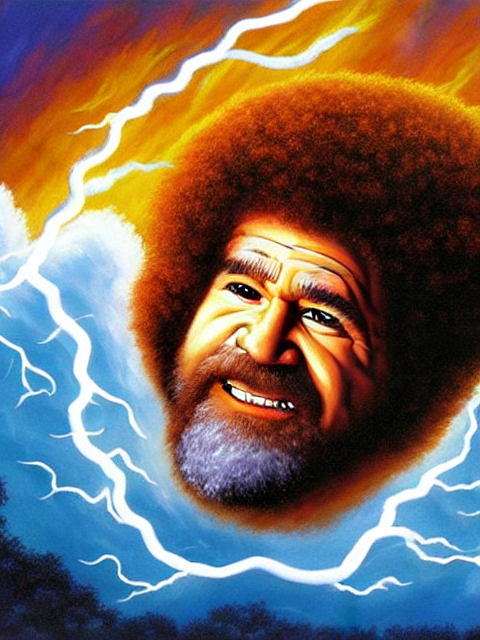

In [4]:
# Setting up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

# Running the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="Bob Ross painting of dragons fighting with lightning background", # What to generate
    negative_prompt="dull colors, low quality", # What NOT to generate
    height=640, width=480,     # Specify the image size
    guidance_scale=12,          # How strongly to follow the prompt
    num_inference_steps=20,    # How many steps to take
    generator=generator        # Fixed random seed
)

# View the resulting image:
pipe_output.images[0]

Hilarious

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

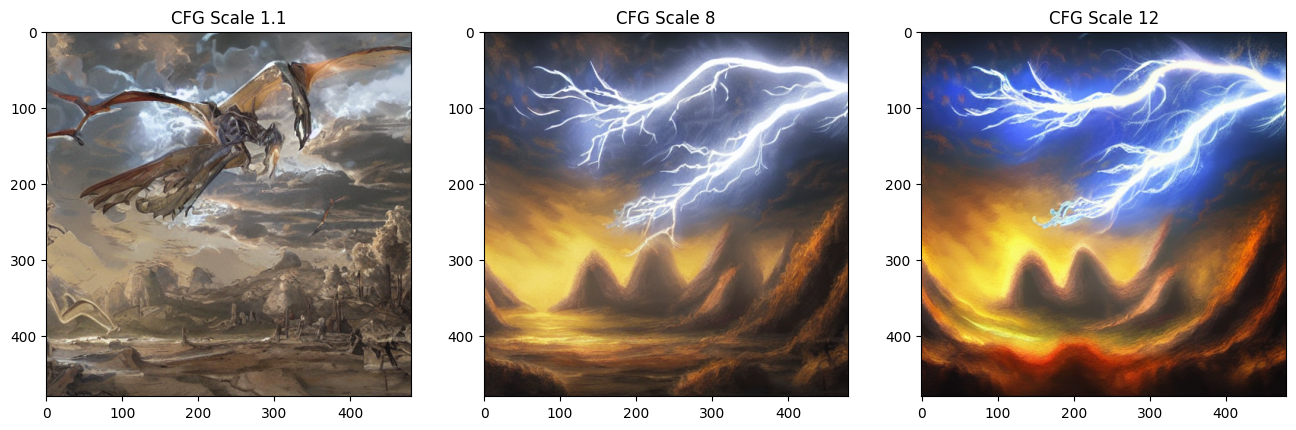

In [5]:
cfg_scales = [1.1, 8, 12] 
prompt = "Dragons fighting with lightning background with Bob Ross Painting Style" 
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
  im = pipe(prompt, height=480, width=480,
    guidance_scale=cfg_scales[i], num_inference_steps=35,
    generator=torch.Generator(device=device).manual_seed(42)).images[0]
  ax.imshow(im); ax.set_title(f'CFG Scale {cfg_scales[i]}');

At guidance 1.1, the output looks more like the prompt though the painting style is not as desired. As the guidance increases, the art style looks more like Bob Ross painting style but there are no dragons in it. So it seems that an intermediate like CFG value 4 or 5 would be more suffice. 

## Pipeline Components

The StableDiffusionPipeline is more complex than DDPMPipeline. In DDPMPipeline, there was only UNet and scheduler and in StableDiffusionPipeline there are more than these components

In [6]:
print(list(pipe.components.keys()))

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor']


### The VAE

VAE stands for Variational Encoder. VAE is a type of model that first encodes the input into a compressed representation and then decodes the latent representation back to something close to original input. While generating images with stable diffusion, we first generate the latents by applying the diffusion process in the 'latent space' of VAE, and then decode them at the end to view the resulting image.

In [8]:
# Creating fake data (a random image)
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1
print("Input images shape: ", images.shape)

# Encoding to latent space
with torch.no_grad():
    latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean 
# 0.18215 is the scale_factor used to scale the latents produced by autoencoders
print("Encoded latents shape: ", latents.shape)

#Decoding again
with torch.no_grad():
    decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape: ", decoded_images.shape)

Input images shape:  torch.Size([1, 3, 512, 512])
Encoded latents shape:  torch.Size([1, 4, 64, 64])
Decoded images shape:  torch.Size([1, 3, 512, 512])


### The Tokenizer and Text Encoder

The aim of text encoder is to turn an input string into a numerical representation that can be fed to UNet as conditioning. The text is first turned into a series of tokens using the pipeline's tokenizer. The text encoder has a vocabulary of about 50K tokens - any word isn't in this vocabulary is split into smaller sub-words. The tokens are then fed to the text encoder - a transformer model that was trained as text encoder for CLIP by OpenAI. 

In [9]:
# Tokenizing
input_ids = pipe.tokenizer(["A painting of a flooble"])['input_ids']
print("Input ID -> decoded token")
for input_id in input_ids[0]:
  print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

# Feeding through CLIP text encoder
input_ids = torch.tensor(input_ids).to(device)
with torch.no_grad():
  text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']
print("Text embeddings shape:", text_embeddings.shape)

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
4062 -> floo
1059 -> ble
49407 -> <|endoftext|>
Text embeddings shape: torch.Size([1, 8, 768])


In [10]:
# Getting the final text embeddings using the pipeline's _encode_prompt function:
text_embeddings = pipe._encode_prompt("A painting of a flooble", device, 1, False, '')
text_embeddings.shape

torch.Size([1, 77, 768])

### The UNet

The UNet takes a noisy input and predicts the noise, just as before. The input is not an image but is instead a latent representation of an image. And in addition to the timestep conditioning, this UNet also takes in the text embeddiings of the prompt as an additional input. 

In [11]:
# Dummy inputs:
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 768).to(device)

# Model prediction:
with torch.no_grad():
    unet_output = pipe.unet(latents, timestep, text_embeddings).sample
print("UNet output shape:", unet_output.shape)

UNet output shape: torch.Size([1, 4, 64, 64])


### The Scheduler

The scheduler stores the noise schedule and manages updating the noisy sample based on the model predictions. The default scheduler is a PNDMScheduler, but others can be used like LMSDiscreteScheduler as long as they are initialized with the same configuration. 

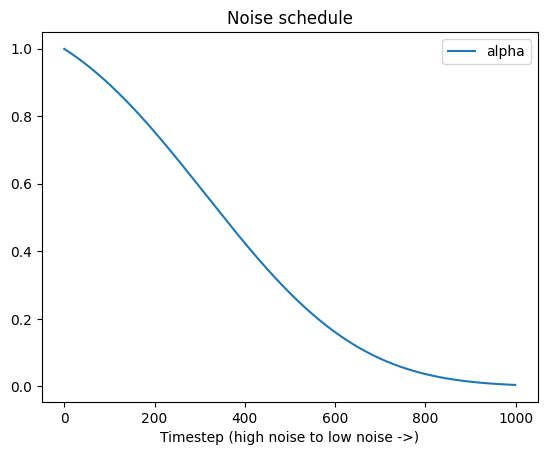

In [12]:
plt.plot(pipe.scheduler.alphas_cumprod, label=r'alpha')
plt.xlabel('Timestep (high noise to low noise ->)');
plt.title('Noise schedule');plt.legend()

### A DIY Sampling Loop

d:\AIProjects\StableDiffusionHF\diffusion\lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:471: FutureWarning: The decode_latents method is deprecated and will be removed in a future version. Please use VaeImageProcessor instead
  warnings.warn(


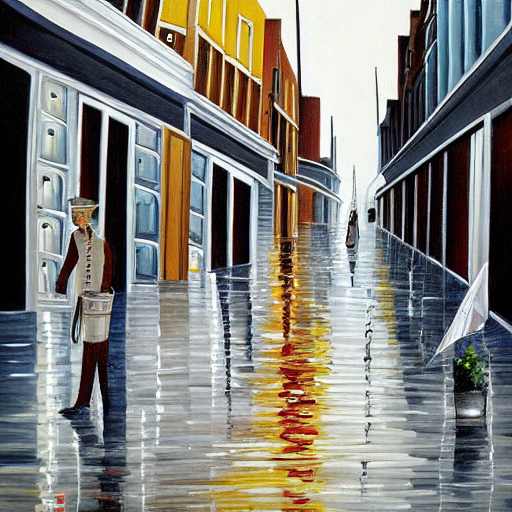

In [19]:
guidance_scale = 6
num_inference_steps = 35
prompt  = "Beautiful painting of wet city street on a rainy day"
negative_prompt = "blurry, oversaturated, low quality"

# Encoding the prompt
text_embedding = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# Creating our random starting point
latents = torch.randn((1, 4, 64, 64), device = device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

# Preparing the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# Looping through the sampling timesteps
for i, t in enumerate(pipe.scheduler.timesteps):

    # expand the latents when classifying free guidance
    latent_model_input = torch.cat([latents] * 2)

    # Applying any scaling required by the scheduler
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual with the unet
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embedding).sample

    # performing guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Computing the previous noisy sample x_t -> x_t - 1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# Decoding the resulting latents into an image
with torch.no_grad():
    image = pipe.decode_latents(latents.detach())

# View
pipe.numpy_to_pil(image)[0]

## Additional Pipelines



### Img2Img
Img2Img pipeline first encodes an existing image into a set of latents, then adds some noise to the latents and uses that as the starting point. The amount of noise added and the number of denoising steps applied determine the 'strength' of the img2img process.

In [20]:
# Loading an Img2Img pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id).to(device)

unet\diffusion_pytorch_model.safetensors not found


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

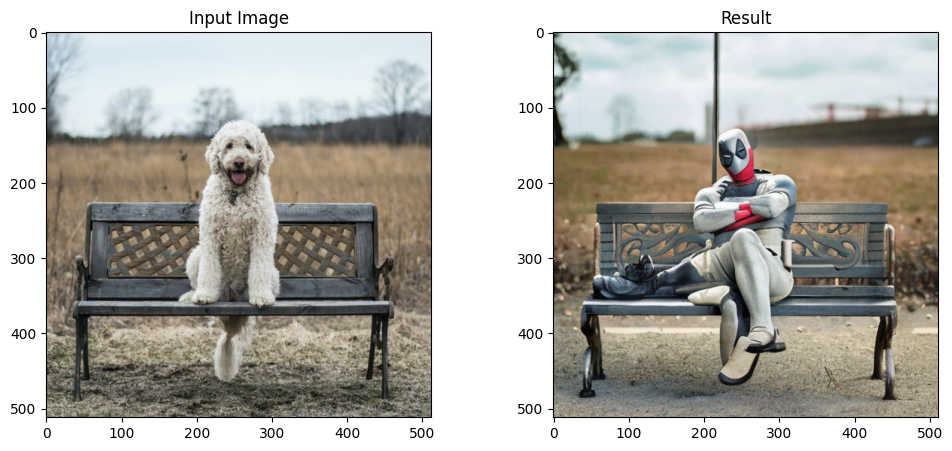

In [24]:
# Apply Img2Img
result_image = img2img_pipe(
    prompt="Realistic image of Deadpool lying on bench",
    image = init_image, # The starting image
    strength = 0.6, # 0 for no change, 1.0 for max strength
).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(result_image);axs[1].set_title('Result');

### In-Painting

In the In-Paint pipeline, a mask is also fed to the UNet model along with text_embedding, noisy latents and timesteps.

In [26]:
# Load the inpainting pipeline (requires a suitable inpainting model)
pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting")
pipe = pipe.to(device)

text_encoder\model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
# Inpaint with a prompt for what we want the result to look like
prompt = "A Robot Dog, high resolution, sitting on a park bench"
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]

# View the result
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(mask_image);axs[1].set_title('Mask')
axs[2].imshow(image);axs[2].set_title('Result');

Was not able to generate an image as GPU had only 6GB VRam and the inpaint pipeline required more.